In [1]:
#@title Import Relevant Libraries
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve,auc,precision_recall_fscore_support
import seaborn as sns

print('Imported libraries')

Imported libraries


In [2]:
#@title create model

def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=25, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                  name='Hidden1'))
    
  model.add(tf.keras.layers.Dropout(rate=0.25))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=15, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

print('Defined Model Creator')

Defined Model Creator


In [3]:
#@title create model trainer

def train_model(model, features_df, label_df, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in features_df.items()}
  label = label_df.to_numpy()
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

print('Defined model trainer')

Defined model trainer


In [4]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [5]:
def plot_confusion_matrix(labels_test,pred):
    cnf_matrix=confusion_matrix(labels_test,pred)
    print("Accuracy : {}", accuracy_score(labels_test,pred))
    print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
    print("ROC", roc_auc_score(labels_test, pred))
    fig= plt.figure(figsize=(6,3))
    print("TP",cnf_matrix[1,1,])
    print("TN",cnf_matrix[0,0])
    print("FP",cnf_matrix[0,1]) 
    print("FN",cnf_matrix[1,0]) 
    
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred))

In [6]:
def data_prep(X,y, num):
    X = X
    y = y
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=num,random_state=42, stratify = y)
    print("========== panjang X train ==========")
    print(str(len(X_train)))
    print("========== panjang X test ===========")
    print(str(len(X_test)))
    return X_train, X_test, y_train, y_test

In [7]:
#@title Extract dataframe from csv
df_raw = pd.read_csv(filepath_or_buffer="./Dataset/credit_train_2.csv")
df_raw = df_raw.reindex(np.random.permutation(df_raw.index))


print('Extracted data from csv')

Extracted data from csv


In [8]:

print("############ DATA_INFO #############")
df_raw.info()

############ DATA_INFO #############
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100514 entries, 24783 to 18927
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   loan_id                       100000 non-null  object 
 1   customer_id                   100000 non-null  object 
 2   loan_status                   100000 non-null  object 
 3   current_loan_amount           100000 non-null  float64
 4   term                          100000 non-null  object 
 5   credit_score                  80846 non-null   float64
 6   annual_income                 80846 non-null   float64
 7   years_in_current_job          95778 non-null   object 
 8   home_ownership                100000 non-null  object 
 9   purpose                       100000 non-null  object 
 10  monthly_debt                  100000 non-null  float64
 11  years_of_credit_history       100000 non-null  float64
 12  mont

In [9]:

df_raw = df_raw[df_raw['credit_score'].notna()]
df_raw = df_raw[df_raw['annual_income'].notna()]
df_raw['current_loan_amount'] = df_raw['current_loan_amount']/1000
df_raw['annual_income'] = df_raw['annual_income']/1000
df_raw['current_credit_balance'] = df_raw['current_credit_balance']/1000
df_raw = df_raw[df_raw['bankruptcies'].notna()]
df_raw = df_raw[df_raw['tax_liens'].notna()]
df_raw = df_raw[df_raw['years_in_current_job'].notna()]
df_raw = df_raw[df_raw['maximum_open_credit'].notna()]
df_raw['months_since_last_delinquent'].fillna(value=0, inplace=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77271 entries, 50253 to 18927
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_id                       77271 non-null  object 
 1   customer_id                   77271 non-null  object 
 2   loan_status                   77271 non-null  object 
 3   current_loan_amount           77271 non-null  float64
 4   term                          77271 non-null  object 
 5   credit_score                  77271 non-null  float64
 6   annual_income                 77271 non-null  float64
 7   years_in_current_job          77271 non-null  object 
 8   home_ownership                77271 non-null  object 
 9   purpose                       77271 non-null  object 
 10  monthly_debt                  77271 non-null  float64
 11  years_of_credit_history       77271 non-null  float64
 12  months_since_last_delinquent  77271 non-null  float64
 1

In [10]:
df_raw.drop(['loan_id', 'customer_id'], axis = 1, inplace=True)
df_raw['loan_status'].replace({'Charged Off':0, 'Fully Paid':1}, inplace=True)
df_raw['term'].replace({'Short Term':0, 'Long Term':1}, inplace=True)
df_raw['years_in_current_job'].replace({'< 1 year':0,
                                          '1 year':1,
                                          '2 years':2,
                                          '3 years':3,
                                          '4 years':4,
                                          '5 years':5,
                                          '6 years':6,
                                          '7 years':7,
                                          '8 years':8,
                                          '9 years':9,
                                          '10+ years': 10},
                                        inplace=True)
df_raw['home_ownership'].replace({'HaveMortgage':1,
                                    'Home Mortgage':2,
                                    'Own Home':3,
                                    'Rent':4},
                                  inplace=True)
df_raw['purpose'].replace({'Business Loan':1,
                             'Buy a Car':2,
                             'Buy House':3,
                             'Debt Consolidation':4,
                             'Educational Expenses':5,
                             'Home Improvements':6,
                             'major_purchase':7,
                             'Medical Bills':8,
                             'moving':9,
                             'renewable_energy':10,
                             'small_business':11,
                             'Take a Trip':12,
                             'vacation':13,
                             'wedding':14,
                             'other':15,
                             'Other':15},
                           inplace=True)

df_raw.head()

,loan_status,current_loan_amount,term,credit_score,annual_income,years_in_current_job,home_ownership,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
50253,1,205.018,0,713.0,1248.680,10,3,4,10176.78,14.7,0.0,11.0,1.0,117.306,330484.0,1.0,0.0
1235,1,443.960,1,638.0,3163.215,4,2,15,67218.39,15.5,8.0,17.0,0.0,120.726,170874.0,0.0,0.0
56534,1,227.612,0,746.0,1232.245,10,4,4,22693.79,21.3,0.0,16.0,0.0,196.175,802670.0,0.0,0.0
26900,1,110.352,0,748.0,857.660,5,1,12,13836.75,17.4,0.0,12.0,0.0,321.689,1455036.0,0.0,0.0
20779,0,123.068,0,7130.0,778.221,2,2,4,17899.14,12.8,0.0,8.0,0.0,315.875,400180.0,0.0,0.0


In [11]:

df_raw.describe()


,loan_status,current_loan_amount,term,credit_score,annual_income,years_in_current_job,home_ownership,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
count,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,77271.000000,7.727100e+04,77271.000000,77271.000000
mean,0.790167,14545.620412,0.291623,1071.759392,1399.186341,5.911066,2.934231,5.215204,18755.666828,17.983421,16.427780,11.201020,0.164641,297.565404,7.395510e+05,0.114299,0.029196
std,0.407192,34869.353548,0.454513,1466.273187,1094.464889,3.630256,0.956108,3.352429,12292.178511,6.796231,23.001615,5.037004,0.481352,384.575361,7.038667e+06,0.347270,0.262642
min,0.000000,15.422000,0.000000,585.000000,76.627000,0.000000,1.000000,1.000000,0.000000,3.700000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,1.000000,193.149000,0.000000,705.000000,862.505000,3.000000,2.000000,4.000000,10478.500000,13.400000,0.000000,8.000000,0.000000,114.351500,2.746260e+05,0.000000,0.000000
50%,1.000000,326.964000,0.000000,724.000000,1202.263000,6.000000,3.000000,4.000000,16475.280000,16.800000,0.000000,10.000000,0.000000,212.724000,4.697000e+05,0.000000,0.000000
75%,1.000000,553.080000,1.000000,741.000000,1677.339000,10.000000,4.000000,4.000000,24302.330000,21.500000,30.000000,14.000000,0.000000,371.269500,7.839040e+05,0.000000,0.000000
max,1.000000,99999.999000,1.000000,7510.000000,165557.393000,10.000000,4.000000,15.000000,435843.280000,70.500000,176.000000,76.000000,15.000000,32878.968000,1.539738e+09,7.000000,15.000000


In [12]:
array = df_raw.values
arr_x = array[3:,3:]
arr_y = array[3:,2]
arr_y = arr_y.astype(int)

In [13]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(arr_x, arr_y)
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(arr_x)
print(features[0:5,:])

[2.038e+05 4.252e+05 8.057e+02 3.389e+02 6.545e+02 1.517e+07 4.917e+02
 1.629e+02 1.150e+03 5.779e+01 4.049e+05 5.213e+08 5.484e+01 2.048e+00]
[[8.577e+02 1.384e+04 3.217e+02 1.455e+06]
 [7.782e+02 1.790e+04 3.159e+02 4.002e+05]
 [1.376e+03 1.869e+04 2.936e+02 5.933e+05]
 [1.187e+03 2.392e+04 7.767e+02 1.131e+06]
 [9.663e+02 3.052e+04 2.684e+02 8.682e+05]]


# Highest scores: Current Loan Amount, Credit Score, Annual Income, Maximum Open Credit

In [14]:
# df_train_mean = df_train.mean()
# df_train_std = df_train.std()
# df_train_norm = (df_train - df_train_mean) / df_train_std

In [15]:
feature_columns = []
current_loan_amount = tf.feature_column.numeric_column('current_loan_amount')
feature_columns.append(current_loan_amount)
credit_score = tf.feature_column.numeric_column('credit_score')
feature_columns.append(credit_score)
annual_income = tf.feature_column.numeric_column('annual_income')
feature_columns.append(annual_income)
max_open_credit = tf.feature_column.numeric_column('maximum_open_credit')
feature_columns.append(max_open_credit)
max_open_credit = tf.feature_column.numeric_column('current_credit_balance')
feature_columns.append(max_open_credit)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [16]:
print(df_raw.copy()['loan_status'])

50253    1
1235     1
56534    1
26900    1
20779    0
        ..
57870    0
48648    1
91530    1
41972    1
18927    1
Name: loan_status, Length: 77271, dtype: int64


In [17]:
X = df_raw.copy().drop(['loan_status'], axis=1)
y = df_raw.copy()['loan_status']
X_train, X_test, y_train, y_test = data_prep(X,y,0.25)

X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

========== panjang X train ==========
57953
========== panjang X test ===========
19318


Train on 57953 samples
Epoch 1/50
57953/57953 [==============================] - 9s 163us/sample - loss: 0.1778 - mean_squared_error: 0.1404
Epoch 2/50
57953/57953 [==============================] - 4s 78us/sample - loss: 0.1315 - mean_squared_error: 0.1265
Epoch 3/50
57953/57953 [==============================] - 5s 89us/sample - loss: 0.1311 - mean_squared_error: 0.1267
Epoch 4/50
57953/57953 [==============================] - 5s 88us/sample - loss: 0.1300 - mean_squared_error: 0.1263
Epoch 5/50
57953/57953 [==============================] - 4s 65us/sample - loss: 0.1305 - mean_squared_error: 0.1269
Epoch 6/50
57953/57953 [==============================] - 4s 62us/sample - loss: 0.1325 - mean_squared_error: 0.1275
Epoch 7/50
57953/57953 [==============================] - 4s 67us/sample - loss: 0.1300 - mean_squared_error: 0.1268
Epoch 8/50
57953/57953 [==============================] - 4s 71us/sample - loss: 0.1300 - mean_squared_error: 0.1269
Epoch 9/50
57953/57953 [================

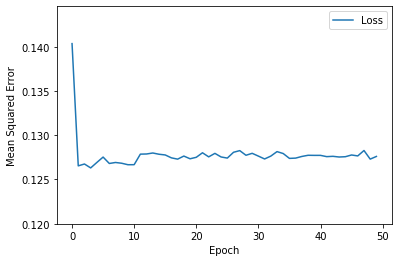

In [18]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 50
batch_size = 100

# Specify the label
label_name = 'loan_status'

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, X_train, y_train, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, mse)

Accuracy : {} 0.8454291334506677
the recall for this model is : 0.9997379454926625
ROC 0.6320840689476139
TP 15260
TN 1072
FP 2982
FN 4


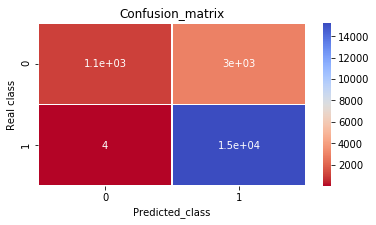


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.26      0.42      4054
           1       0.84      1.00      0.91     15264

    accuracy                           0.85     19318
   macro avg       0.92      0.63      0.66     19318
weighted avg       0.87      0.85      0.81     19318



In [19]:
threshold = 0.5

test_x = {name:np.array(value) for name, value in X_test.items()}
y_pred = my_model.predict(test_x)
y_pred = [int(1) if x>threshold else int(0) for x in y_pred]

y_test = y_test.astype('int')
plot_confusion_matrix(y_test, y_pred)